# Fit emimTF2N data

EoS: SRK

Parameter T dependence: Linear in [emimTF2N,R125] direction

N (total fitting parameters): 3

## Import Functions

In [1]:
import idaes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import sys
sys.path.append('../../')

from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)
from pyomo.opt import TerminationCondition, SolverStatus

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom

# parmest (binary_param2)
from bip_fitting_functions_SRK import linear

import scipy.stats as stats

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches

## Load Data

In [2]:
data_full = pd.read_csv('r125_emimtf2n_full.csv')
data_subset = pd.read_csv('r125_emimtf2n_subset.csv')

## Load Configuration + Check DOF

In [3]:
from hfc125_emimtf2n_SRK import configuration 

In [4]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

The initial DOF is 7


## Fit Parameters

In [5]:
parameters, obj_value, a = linear(data_subset, configuration, 'R125', 'emimTf2N', "x_R125", "x_emimTf2N", 
    init_temp =  283.1, init_press =   399300 , init_x_c1 =    0.448, init_x_c2 = 0.552,
    init_kappa_2_1A = -0.002, init_kappa_1_2A = -0.005,
    init_kappa_2_1B = -0.001, init_kappa_1_2B = 0.0, eps = 0.1, scaling_fac = 1e-9,optional_params = 'Opt2')

2022-04-05 16:56:50 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-05 16:56:50 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-05 16:56:50 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-05 16:56:51 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-05 16:56:51 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-05 16:56:51 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-05 16:56:52 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-05 16:56:52 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-05 16:56:52 [INFO] idaes

The SSE at the optimal solution is 0.129105

The values for the parameters are as follows:
fs.properties.SRK_kappa_A[R125,emimTf2N] = -0.029704632920881224
fs.properties.SRK_kappa_A[emimTf2N,R125] = 0.08236174906327659
fs.properties.SRK_kappa_B[emimTf2N,R125] = -0.14422435783402843
covariance_matrix                                           fs.properties.SRK_kappa_A[R125,emimTf2N]  \
fs.properties.SRK_kappa_A[R125,emimTf2N]                                  0.000001   
fs.properties.SRK_kappa_A[emimTf2N,R125]                                 -0.000120   
fs.properties.SRK_kappa_B[emimTf2N,R125]                                  0.000132   

                                          fs.properties.SRK_kappa_A[emimTf2N,R125]  \
fs.properties.SRK_kappa_A[R125,emimTf2N]                                 -0.000120   
fs.properties.SRK_kappa_A[emimTf2N,R125]                                  0.020153   
fs.properties.SRK_kappa_B[emimTf2N,R125]                                 -0.021441   

         

In [6]:
print('Objective (SSE):',obj_value)

Objective (SSE): 0.12910525594134523


In [7]:
parameters

fs.properties.SRK_kappa_A[R125,emimTf2N]   -0.029705
fs.properties.SRK_kappa_A[emimTf2N,R125]    0.082362
fs.properties.SRK_kappa_B[emimTf2N,R125]   -0.144224
dtype: float64

In [8]:
cov = np.array(a)
print('Covariance Matrix:')
print(cov)

Covariance Matrix:
[[ 1.29449670e-06 -1.20108333e-04  1.32377440e-04]
 [-1.20108333e-04  2.01532676e-02 -2.14407030e-02]
 [ 1.32377440e-04 -2.14407030e-02  2.28668173e-02]]


In [9]:
np.savetxt('Data/Covariance/SRK_Cov_3parameter_HFCILB0.csv',cov,delimiter=',')

## Apply Parameters + Plot

In [10]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [11]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(0.5)

m.fs.properties.SRK_kappa_A['R125','emimTf2N'] = parameters['fs.properties.SRK_kappa_A[R125,emimTf2N]']
m.fs.properties.SRK_kappa_A['emimTf2N','R125'] = parameters['fs.properties.SRK_kappa_A[emimTf2N,R125]']
# m.fs.properties.PR_kappa_B['R32','emimTf2N'] = parameters['fs.properties.PR_kappa_B[R32,emimTf2N]']
m.fs.properties.SRK_kappa_B['emimTf2N','R125'] = parameters['fs.properties.SRK_kappa_B[emimTf2N,R125]']

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

R125_x = np.zeros((len(data_full)))
P = np.zeros((len(data_full)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

for i in range(len(data_full)):
    m.fs.liq = data_full["x_emimTf2N"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data_full["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(float(data_full["x_R125"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data_full["x_R125"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    
#     DOF_final = degrees_of_freedom(m)
#     print("The final DOF is {0}".format(DOF_final))
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    status = solver.solve(m, tee = False)

#     m.fs.F101.report()
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
        print(data_full["x_emimTf2N"].iloc[i])
        R125_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
        P[i] = value(m.fs.F101.vap_outlet.pressure[0])

    else:
        print('Infeasible.')

0.992
0.915
0.832
0.75
0.669
0.587
0.504
0.417
0.319
0.994
0.945
0.891
0.839
0.787
0.733
0.683
0.578
0.479
0.996
0.97
0.941
0.912
0.883
0.848
0.824
0.772
0.715
0.996
0.982
0.966
0.95
0.926
0.903
0.895
0.86
0.829


In [12]:
fitted_data = pd.DataFrame(data=[R125_x,P/1e6])
fitted_data = fitted_data.T
fitted_data.columns = ['R125_x','P, MPa']
fitted_data.to_csv('Data/Fits/SRK_FittedData_3parameter_HFCILB0.csv')

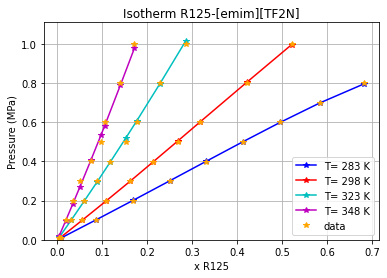

In [13]:
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

plt.plot(R125_x[0:9],P1[0:9],"b*-",label="T= 283 K")  
plt.plot(R125_x[9:18],P1[9:18],"r*-",label="T= 298 K") 
plt.plot(R125_x[18:27],P1[18:27],"c*-",label="T= 323 K") 
plt.plot(R125_x[27:],P1[27:],"m-*",label="T= 348 K")
plt.plot(data_full["x_R125"],data_full["pressure"]/1e6,"*",color='orange',label="data")  
plt.title('Isotherm R125-[emim][TF2N]')
plt.ylabel('Pressure (MPa)')
plt.xlabel('x R125')
plt.grid(True)
plt.ylim(0,1.110000)
plt.legend()
plt.show()

### Print Eigvals, Eigvectors

An identifiability analysis can be performed with these as well as a FIM because the covariance matrix is the inverse of the FIM. That means that if there are any eigvals > 0, their eigvecs indicate directions of un-identifiability.

In [14]:
eigvals, eigvecs = np.linalg.eig(cov)

In [15]:
eigvals

array([4.29943741e-02, 2.01663722e-07, 2.68036793e-05])

In [16]:
eigvecs

array([[-0.0041569 ,  0.99339292,  0.11468753],
       [ 0.68440822, -0.08079239,  0.72460885],
       [-0.72908718, -0.08150521,  0.67955043]])

In [17]:
np.savetxt('Data/EigenAnalysis/SRK_vals_3parameter_HFCILB0.csv',eigvals,delimiter=',')
np.savetxt('Data/EigenAnalysis/SRK_vecs_3parameter_HFCILB0.csv',eigvecs,delimiter=',')

Conclusion: 

## AIC Value

See https://docs.google.com/document/d/1um0r2XK4ldjjy2colOqaZsEM3wIzGD6l_3B8gnpnI2I/edit# for equations

In [18]:
n = 3

In [19]:
SSR = obj_value

In [20]:
sigma_sq = SSR/n
sigma_sq

0.043035085313781744

In [21]:
L = -n/2*np.log(2*np.pi) - n/2*np.log(sigma_sq) - 1/(2*sigma_sq)*SSR
L

0.4617937380682311

In [22]:
AIC = 2*n - 2*L
AIC

5.076412523863538

In [23]:
AIC_data = pd.DataFrame(data=[n,obj_value,AIC])
AIC_data = AIC_data.T
AIC_data.columns = ['n','Objective, Pa^2','AIC']
AIC_data.to_csv('Data/AIC/SRK_AIC_3parameter_HFCILB0.csv')